In [1]:
# inverse m and loss for all models (tested Apr 1) and datasets

import torch
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
model_names = ["facebook/opt-125m",
               "facebook/opt-350m",
               "facebook/opt-1.3B",
               "facebook/opt-2.7B",
               "facebook/opt-6.7B",
               "facebook/opt-13B",
               "facebook/opt-30B",
               "facebook/opt-66b",
               "Qwen/Qwen2.5-0.5B",
               "Qwen/Qwen2.5-1.5B",
               "Qwen/Qwen2.5-3B",
               "Qwen/Qwen2.5-7B",
               "Qwen/Qwen2.5-14B",
               "Qwen/Qwen2.5-32B",
               "Qwen/Qwen2.5-72B",
               "openai-community/gpt2",
               "openai-community/gpt2-medium",
               "openai-community/gpt2-large",
               "openai-community/gpt2-xl",
               "EleutherAI/pythia-70m",
               "EleutherAI/pythia-160m",
               "EleutherAI/pythia-410m",
               "EleutherAI/pythia-1b",
               "EleutherAI/pythia-1.4b",
               "EleutherAI/pythia-2.8b",
               "EleutherAI/pythia-6.9b",
               "EleutherAI/pythia-12b"]

data_names = ["wikitext",
              "c4",
              "pile",
              "bookcorpus"]

model_classes = ["opt",
                 "Qwen",
                 "gpt2",
                 "pythia"]

len(model_names)

27

In [3]:
results = []
for model_name in model_names:
    with open(f"./data/{model_name.replace('/', '_')}_results.json", "r") as f:
        result = json.load(f)
    result['m'] = torch.load(f"./data/overlap-0-{model_name.replace('/', '_')}.pt", weights_only=False)['m'] if model_name != "facebook/opt-350m" else 1024
    results.append(result)

In [4]:
losses_groups = []
ms_groups = []

for model_class in model_classes:
    for data_name in data_names:
        losses = []
        ms = []
        for result in results:
            if model_class in result['model_id']:
                losses.append(result['results'][data_name]['loss'])
                ms.append(result['m'])
        losses_groups.append(torch.tensor(losses))
        ms_groups.append(torch.tensor(ms))

In [13]:
log_mean_m = 0
num_data = 0
for ms in ms_groups:
    log_mean_m +=  ms.log().sum()
    num_data += len(ms)
log_mean_m = log_mean_m / num_data

In [6]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.A = torch.nn.Parameter(torch.tensor([500.0]))
        self.B = torch.nn.Parameter(torch.ones(16))
        self.alpha = torch.nn.Parameter(torch.tensor([1.0]))

    def forward(self, x_group, y_group):
        loss = 0
        num_data = 0
        for i, x, y in zip(range(len(x_group)), x_group, y_group):
            loss += ((self.A / x.pow(self.alpha) + self.B[i] - y) ** 2).sum() 
            num_data += x.numel()
        return loss / num_data

model = Model()
optimizer = torch.optim.Adam([{"params":model.A, "lr": 1.0}, {"params":model.B, "lr": 0.001}, {"params":model.alpha, "lr": 0.001}])

for i in range(20000):
    optimizer.zero_grad()
    loss = model(ms_groups, losses_groups)
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

Iteration 0, Loss: 1.742314100265503
Iteration 1000, Loss: 0.1029869019985199
Iteration 2000, Loss: 0.022384051233530045
Iteration 3000, Loss: 0.006268143188208342
Iteration 4000, Loss: 0.00539284385740757
Iteration 5000, Loss: 0.005365414544939995
Iteration 6000, Loss: 0.005335673224180937
Iteration 7000, Loss: 0.005299288779497147
Iteration 8000, Loss: 0.005261349491775036
Iteration 9000, Loss: 0.00522950291633606
Iteration 10000, Loss: 0.0052092731930315495
Iteration 11000, Loss: 0.005200320389121771
Iteration 12000, Loss: 0.005197944585233927
Iteration 13000, Loss: 0.005197660997509956
Iteration 14000, Loss: 0.0051976535469293594
Iteration 15000, Loss: 0.005197728518396616
Iteration 16000, Loss: 0.005197750870138407
Iteration 17000, Loss: 0.005197649355977774
Iteration 18000, Loss: 0.005197652615606785
Iteration 19000, Loss: 0.005197651218622923


In [7]:
model.alpha.data, model.A.data, model.B.data

(tensor([0.9098]),
 tensor([476.0763]),
 tensor([2.2074, 2.2745, 1.7193, 2.1845, 1.6079, 2.1009, 1.4890, 1.9348, 2.3018,
         2.3546, 1.9413, 2.2961, 2.1407, 2.2998, 1.5203, 2.2415]))

In [8]:
Bs = model.B.data

In [9]:
shapes = ['o', 's', 'v', '^']
colors = ['C0', 'C1', 'C2', 'C3']

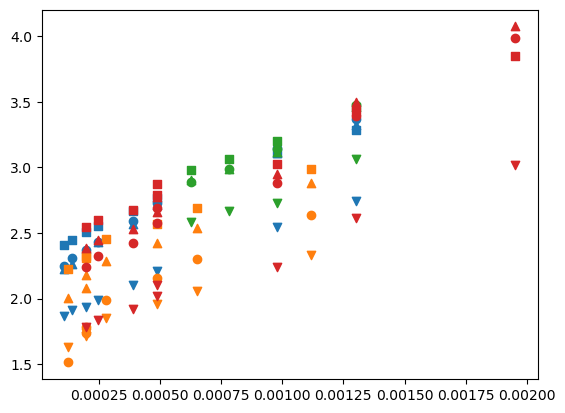

In [10]:
for model_i in range(4):
    for data_i in range(4):
        idx = model_i * 4 + data_i
        plt.scatter(1 / ms_groups[idx], losses_groups[idx], marker=shapes[data_i], color=colors[model_i])

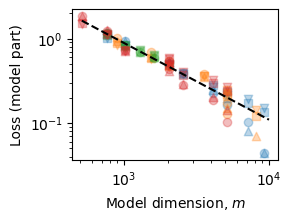

In [11]:
plt.figure(figsize=(2.8, 2.1), constrained_layout=True)
for model_i in range(4):
    for data_i in range(4):
        idx = model_i * 4 + data_i
        plt.scatter(ms_groups[idx], losses_groups[idx] - Bs[idx], marker=shapes[data_i], color=colors[model_i], alpha=0.3)

plt.plot(torch.linspace(512, 1e+4, 100), model.A.data / torch.linspace(512, 1e+4, 100).pow(model.alpha.data), color='black', linestyle='--')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Model dimension, $m$')
plt.ylabel('Loss (model part)')
plt.savefig('../figures/loss_vs_m.pdf')

In [20]:
y_diff = 0
x_diff = 0
for i, (losses, ms) in enumerate(zip(losses_groups, ms_groups)):
    y_diff += ((losses - Bs[i]).log().nan_to_num() - (model.A.data / ms.pow(model.alpha.data)).log()).pow(2).sum()
    x_diff += (ms.log() - log_mean_m).pow(2).sum()
err_slope = (y_diff / x_diff / (num_data - 3)).sqrt()
print(f"Error in slope: {err_slope.item()}")

Error in slope: 0.03599117696285248


In [16]:
dist_wd_names = ["exponential1_-1.00",
            "exponential1_0.10",
            "power_-1.00",
            "power_0.10",
            "linear_-1.00",
            "linear_0.10"]

n_steps = 40000
m_ran = 2 ** torch.arange(3, 11)
tlosses = torch.zeros((len(dist_wd_names), len(m_ran), n_steps))

for i, dist_wd_name in enumerate(dist_wd_names):
    result = torch.load(f"../outputs/exp-17-{dist_wd_name}.pt", weights_only=False)
    #tlosses[i] = result['losses'] 
    tlosses[i,:,-result['losses'].shape[-1]:] = result['losses']

In [17]:
fit_losses = tlosses[:,:,-100:].mean(dim = -1) * 10240
std_losses = tlosses[:,:,-100:].std(dim = -1) * 10240

In [18]:
from scipy import stats
import math

-1.0054519891134572
-0.984016743248084
-0.8863921247731672


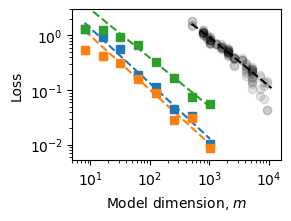

In [27]:
plt.figure(figsize=(2.8, 2.1), constrained_layout=True)
for model_i in range(4):
    for data_i in range(4):
        idx = model_i * 4 + data_i
        plt.scatter(ms_groups[idx], losses_groups[idx] - Bs[idx], marker='o', color='black', alpha=0.1)

starts = [0, 2, 2]
for iii, i in enumerate([0,2,4]):
    slope, intersect, _, _, slope_std = stats.linregress(torch.log(m_ran[starts[iii]:]), torch.log(fit_losses[i,starts[iii]:]))
    print(slope)
    plt.errorbar(m_ran.numpy(), fit_losses[i].numpy(), yerr=std_losses[i].numpy(), fmt='s', color = 'C'+str(i//2))
    plt.plot(m_ran, math.exp(intersect) * m_ran ** slope, '--', color = 'C'+str(i//2))

plt.plot(torch.linspace(500, 1.1e+4, 100), model.A.data / torch.linspace(512, 1e+4, 100).pow(model.alpha.data), color='black', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim(5,)
plt.ylim(None, 3)
plt.xlabel(r"Model dimension, $m$")
plt.ylabel(r"Loss")
plt.savefig('../figures/exp-17-sup.pdf')